# Catégorisation automatique de questions

## Initialisation

In [248]:
# Standard libraries
import collections
import functools
import itertools
import math
import operator
import os
import re
import string
import sys

# External libraries
import bs4
import matplotlib 
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pickle
import pyLDAvis
import pyLDAvis.sklearn
import scipy
import seaborn as sns
import sklearn as sk
import sklearn.decomposition
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_selection
import sklearn.model_selection
import sklearn.multiclass
import sklearn.multioutput
import sklearn.naive_bayes
import sklearn.svm
import spacy
import spacy.lang

In [285]:
# Fichiers de données sauvegardés par le calepin d'exploration
DATA_FILE = "data/P6 all labels.dat"
DATA_FILE_SINGLE_LABEL = "data/P6 single label.dat"

# Ne pas exécuter les sections à temps de calcul élever
CALC_SLOW_SECTIONS = True

# Sauvegarder les modèles pour exécution par le serveur http
EXPORT_MODELS = True
MODEL1_FILE = "data/supervised_model.sav"
MODEL2_FILE = "data/unsupervised_model.sav"

SEED = 1911

In [3]:
data = pickle.load(open(DATA_FILE, 'rb'))
df, tags, id_to_tag, features = data
df1 = pickle.load(open(DATA_FILE_SINGLE_LABEL, 'rb'))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42191 entries, 1 to 49457
Data columns (total 4 columns):
Id              42191 non-null int64
Tags            42191 non-null object
OriginalTags    42191 non-null object
Text            42191 non-null object
dtypes: int64(1), object(3)
memory usage: 1.6+ MB


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40917 entries, 1 to 49457
Data columns (total 5 columns):
Id              40917 non-null int64
OriginalTags    40917 non-null object
Tag             40917 non-null object
TagCode         40917 non-null int64
Text            40917 non-null object
dtypes: int64(2), object(3)
memory usage: 1.9+ MB


## Classement mono-label

### Représentation des messages en matrice TFIDF

In [6]:
# On ne conserve que les labels fréquents
#df1 = df[~del_mask].copy()
# Utilisation de `min_df` nécessaire pour réduire la quantité de mots
fv = TfidfVectorizer(analyzer='word', ngram_range=(1,2), 
                     min_df=50, stop_words='english')
text_tfidf = fv.fit_transform(df1['Text'])
print(f"Taille de la matrice Tfidf : {text_tfidf.shape}")

Taille de la matrice Tfidf : (40917, 8111)


In [7]:
print(f"{len(fv.stop_words_)} termes exclus")
#print(" ".join(fv.stop_words_))

2014375 termes exclus


In [8]:
X = text_tfidf
y = df1['TagCode']
X_tr, X_t, y_tr, y_t = sk.model_selection.train_test_split(X, y, 
                                                           test_size=0.3, 
                                                           random_state=SEED)
X_tr.shape, y_tr.shape, X_t.shape, y_t.shape

((28641, 8111), (28641,), (12276, 8111), (12276,))

### Mots et bi-grammes les plus corrélés avec chaque catégorie

In [9]:
n_terms = 3
for label, id in [(id_to_tag[id], id) for id in df1['TagCode'].unique()]:
    chi2 = sk.feature_selection.chi2(text_tfidf.toarray(), 
                                     df1['TagCode'] == id)
    indices = np.argsort(chi2[0])
    feature_names = np.array(fv.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]        
    print(label, ":", unigrams[-n_terms:], bigrams[-n_terms:])

python : ['np', 'self', 'python'] ['init self', 'pd dataframe', 'py line']
java : ['javascript', 'javafx', 'java'] ['main string', 'static void', 'import java']
node.js : ['req', 'express', 'nodejs'] ['req body', 'function req', 'require express']
android : ['layout', 'intent', 'android'] ['override public', 'android studio', 'android layout']
pandas : ['dataframe', 'panda', 'df'] ['miss value', 'df df', 'pd dataframe']
bash : ['echo', 'sed', 'bash'] ['bin bash', 'shell script', 'bash script']
api : ['response', 'partner', 'api'] ['api endpoint', 'com api', 'make api']
vue : ['vuex', 'vuetify', 'vue'] ['div template', 'vue component', 'new vue']
flutter : ['widget', 'dart', 'flutter'] ['widget build', 'child widget', 'buildcontext context']
c++ : ['cpp', 'cout', 'std'] ['include iostream', 'std cout', 'std string']
facebook : ['instagram', 'fb', 'facebook'] ['app id', 'access token', 'facebook com']
css : ['cs', 'div', 'px'] ['width px', 'div div', 'div class']
ruby-on-rails : ['active

tensorflow : ['kera', 'tf', 'tensorflow'] ['kera model', 'kera layer', 'tf kera']
google-maps : ['google', 'map', 'marker'] ['map api', 'new google', 'google map']
unity : ['texture', 'gameobject', 'unity'] ['build android', 'build fail', 'debug log']
symfony : ['entity', 'orm', 'symfony'] ['column type', 'entity class', 'public function']


### Modèle bayésien naïf multinomial 

In [10]:
model = sk.naive_bayes.MultinomialNB()
model.fit(X_tr, y_tr)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [11]:
def print_scores(y, y_pred):
    score = sk.metrics.recall_score(y, y_pred, average='micro')    
    print(f"Rappel = {score:0.2f}")
    score = sk.metrics.precision_score(y, y_pred, average='micro')
    print(f"Précision = {score:0.2f}")
    score = sk.metrics.f1_score(y, y_pred, average='micro')
    print(f"F1 = {score:0.2f}")    
    score = sk.metrics.accuracy_score(y, y_pred)    
    print(f"Justesse = {score:0.2f}")    
    print()

In [12]:
print("*** Scores sur données d'entraînement")
y_pred = model.predict(X_tr)
print_scores(y_tr, y_pred)
print("*** Scores sur données de test :")
y_pred = model.predict(X_t)
print_scores(y_t, y_pred)

*** Scores sur données d'entraînement
Rappel = 0.45
Précision = 0.45
F1 = 0.45
Justesse = 0.45

*** Scores sur données de test :
Rappel = 0.42
Précision = 0.42
F1 = 0.42
Justesse = 0.42



In [13]:
names = [id_to_tag[i] for i in y_t.sort_values().unique()]
print(sk.metrics.classification_report(y_t, y_pred, 
                                       target_names=names))

C:\Users\regclem\.conda\envs\tagging_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 precision    recall  f1-score   support

         python       0.32      0.97      0.48      1805
           java       0.26      0.70      0.38       909
        node.js       0.51      0.18      0.26       197
        android       0.65      0.77      0.70       512
         pandas       0.00      0.00      0.00        11
           bash       0.00      0.00      0.00        73
            api       0.00      0.00      0.00        45
            vue       0.90      0.17      0.29       161
        flutter       0.96      0.41      0.57       165
            c++       0.83      0.47      0.60       283
       facebook       0.00      0.00      0.00        24
            css       0.50      0.74      0.60       281
  ruby-on-rails       0.80      0.04      0.08        93
          mysql       0.48      0.45      0.47       315
         django       0.95      0.43      0.59       258
             c#       0.52      0.65      0.58       586
          react       0.60    

In [14]:
# Example
row = 0
v = text_tfidf[row, :]
predicted = model.predict(v)[0]
expected = df1.iloc[row]['TagCode']
print(f"Labels prédit et attendu pour ligne {row} : {predicted, expected}")
df.iloc[row]

Labels prédit et attendu pour ligne 0 : (0, 0)


Id                                                       57560002
Tags                                             {python, amazon}
OriginalTags    <python><amazon-web-services><amazon-s3><boto3...
Text            python script size sthree bucket clanguagesv s...
Name: 1, dtype: object

### Régression logistique

In [15]:
model = sk.linear_model.LogisticRegression(multi_class='multinomial', 
                                           solver='sag')
model.fit(X_tr, y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
print("*** Scores sur données d'entraînement")
y_pred = model.predict(X_tr)
print_scores(y_tr, y_pred)
print("*** Scores sur données de test :")
y_pred = model.predict(X_t)
print_scores(y_t, y_pred)

*** Scores sur données d'entraînement
Rappel = 0.71
Précision = 0.71
F1 = 0.71
Justesse = 0.71

*** Scores sur données de test :
Rappel = 0.61
Précision = 0.61
F1 = 0.61
Justesse = 0.61



In [17]:
names = [id_to_tag[i] for i in y_t.sort_values().unique()]
print(sk.metrics.classification_report(y_t, y_pred, 
                                       target_names=names))

                 precision    recall  f1-score   support

         python       0.59      0.92      0.72      1805
           java       0.39      0.67      0.49       909
        node.js       0.53      0.52      0.52       197
        android       0.67      0.82      0.74       512
         pandas       0.00      0.00      0.00        11
           bash       0.68      0.38      0.49        73
            api       0.12      0.02      0.04        45
            vue       0.90      0.65      0.75       161
        flutter       0.93      0.68      0.79       165
            c++       0.84      0.74      0.79       283
       facebook       0.86      0.50      0.63        24
            css       0.57      0.77      0.66       281
  ruby-on-rails       0.78      0.62      0.69        93
          mysql       0.53      0.61      0.57       315
         django       0.94      0.73      0.83       258
             c#       0.55      0.73      0.63       586
          react       0.84    

### SVM linéaire

#### Optimisation des hyperparamètres

In [18]:
base = sk.svm.LinearSVC(dual=False, random_state=SEED)
grid = {'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'max_iter': [1000, 2000, 5000]
       }
model = sk.model_selection.GridSearchCV(base,
                                        param_grid=grid,
                                        cv=5,
                                        n_jobs=-1)
if CALC_SLOW_SECTIONS:
    model.fit(X_tr, y_tr)
    model.best_params_

Résultats : {'C': 1, 'penalty': 'l1', 'max_iter': 1000}

#### Entraînement du modèle

In [19]:
model = sk.svm.LinearSVC(C=1.0, penalty='l1', max_iter=1000, dual=False)
model.fit(X_tr, y_tr)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
          verbose=0)

In [20]:
print("*** Scores sur données d'entraînement")
y_pred = model.predict(X_tr)
print_scores(y_tr, y_pred)
print("*** Scores sur données de test :")
y_pred = model.predict(X_t)
print_scores(y_t, y_pred)

*** Scores sur données d'entraînement
Rappel = 0.83
Précision = 0.83
F1 = 0.83
Justesse = 0.83

*** Scores sur données de test :
Rappel = 0.65
Précision = 0.65
F1 = 0.65
Justesse = 0.65




## Classement multilabel

### Réduction de dimension de la matrice documents-termes
Pas nécessaire pour l'instant, mais à faire quand même

In [286]:
fv = TfidfVectorizer(analyzer='word', min_df=20, max_df=0.3, 
                     ngram_range=(1, 1))
text_tfidf = fv.fit_transform(df['Text'])
print(f"Taille de la matrice TFIDF : {text_tfidf.shape}")
X = text_tfidf
y = tags
X_tr, X_t, y_tr, y_t = sk.model_selection.train_test_split(X, y, 
                                                           test_size=0.3, 
                                                           random_state=SEED)
X_tr.shape, y_tr.shape, X_t.shape, y_t.shape

Taille de la matrice TFIDF : (42191, 7060)


((29533, 7060), (29533, 149), (12658, 7060), (12658, 149))

In [22]:
print(f"{len(fv.stop_words_)} termes exclus")
#print(" ".join(fv.stop_words_))

199831 termes exclus


### Classement indépendant par catégorie

#### Modèle MultinomialNB

In [23]:
y_pred_t = scipy.sparse.lil_matrix(y_t.shape)
y_pred_tr = scipy.sparse.lil_matrix(y_tr.shape)
model = sk.naive_bayes.MultinomialNB(fit_prior=True, 
                                     class_prior=None)
for i, feature in enumerate(features):
    y_label_tr = y_tr[:, i].toarray().reshape(-1)
    y_label_t = y_t[:, i].toarray().reshape(-1)
    model.fit(X_tr.toarray(), y_label_tr)    
    y_pred1_tr = model.predict(X_tr)
    y_pred1_t = model.predict(X_t)
    score_tr = sk.metrics.recall_score(y_label_tr, y_pred1_tr)
    score_t = sk.metrics.recall_score(y_label_t, y_pred1_t)
    y_pred_t[:, i] = y_pred1_t.reshape(-1, 1)
    y_pred_tr[:, i] = y_pred1_tr.reshape(-1, 1)
    print(f"{feature} ({score_tr*100:0.0f}%, {score_t*100:0.0f}%)", end=' ')

.net (0%, 0%) ajax (0%, 0%) algorithm (0%, 0%) amazon (11%, 8%) android (48%, 47%) angular (15%, 15%) ansible (0%, 0%) apache (8%, 4%) api (0%, 0%) arrays (0%, 0%) asp.net (6%, 4%) asynchronous (0%, 0%) authentication (0%, 0%) aws (0%, 0%) azure (3%, 1%) bash (1%, 0%) beautifulsoup (0%, 0%) bootstrap (1%, 0%) c (1%, 2%) c# (15%, 13%) c++ (18%, 18%) class (0%, 0%) css (40%, 36%) csv (0%, 0%) dart (4%, 1%) database (0%, 0%) dataframe (0%, 1%) date (0%, 0%) datetime (0%, 0%) deep-learning (0%, 0%) dictionary (0%, 0%) django (9%, 9%) docker (11%, 8%) dplyr (0%, 0%) ecma (0%, 0%) elasticsearch (1%, 0%) eloquent (0%, 0%) entity-framework (0%, 0%) excel (22%, 26%) express (0%, 0%) facebook (0%, 0%) file (0%, 0%) firebase (4%, 5%) flask (0%, 0%) flutter (27%, 28%) for-loop (0%, 0%) forms (0%, 0%) function (0%, 0%) ggplot2 (0%, 0%) git (0%, 0%) github (0%, 0%) go (0%, 0%) google-app (3%, 2%) google-chrome (0%, 0%) google-cloud (0%, 0%) google-maps (0%, 0%) google-sheets (0%, 0%) gradle (0%, 0%)

In [24]:
print_scores(y_t, y_pred_t)

Rappel = 0.16
Précision = 0.82
F1 = 0.26
Justesse = 0.09



Rappel = 0.16
Précision = 0.80
F1 = 0.26
Justesse = 0.09

#### Régression logistique

In [25]:
filename = "data/P6-MultiLabelLogisticRegressionOutput.sav"

if CALC_SLOW_SECTIONS or True:
    y_pred_t = scipy.sparse.lil_matrix(y_t.shape)
    y_pred_tr = scipy.sparse.lil_matrix(y_tr.shape)
    model = sk.linear_model.LogisticRegression(multi_class='multinomial', 
                                               solver='sag', n_jobs=4)

    for i, f in enumerate(features):
        y_label_tr = y_tr[:, i].toarray().reshape(-1)
        y_label_t = y_t[:, i].toarray().reshape(-1)
        model.fit(X_tr.toarray(), y_label_tr)    
        y_pred1_tr = model.predict(X_tr)
        y_pred1_t = model.predict(X_t)
        score_tr = sk.metrics.recall_score(y_label_tr, y_pred1_tr)
        score_t = sk.metrics.recall_score(y_label_t, y_pred1_t)
        y_pred_t[:, i] = y_pred1_t.reshape(-1, 1)
        y_pred_tr[:, i] = y_pred1_tr.reshape(-1, 1)
        print(f"{f} ({score_tr*100:0.0f}%, {score_t*100:0.0f}%)", end=' ')
        data = (y_pred_tr, y_pred_t)
        pickle.dump(data, open(filename, 'wb'))
else:
    y_pred_tr, y_pred_t = pickle.load(open(filename, 'rb'))
    print(y_pred_tr.shape, y_pred_t.shape)

.net (11%, 6%) ajax (36%, 29%) algorithm (7%, 0%) amazon (58%, 55%) android (73%, 66%) angular (67%, 56%) ansible (48%, 47%) apache (46%, 33%) api (5%, 1%) arrays (28%, 17%) asp.net (45%, 44%) asynchronous (3%, 0%) authentication (4%, 0%) aws (27%, 29%) azure (63%, 51%) bash (30%, 24%) beautifulsoup (38%, 27%) bootstrap (29%, 14%) c (39%, 36%) c# (52%, 44%) c++ (59%, 50%) class (1%, 3%) css (59%, 50%) csv (25%, 21%) dart (33%, 21%) database (0%, 1%) dataframe (17%, 19%) date (6%, 4%) datetime (19%, 5%) deep-learning (1%, 0%) dictionary (16%, 9%) django (72%, 60%) docker (70%, 59%) dplyr (12%, 6%) ecma (0%, 0%) elasticsearch (51%, 37%) eloquent (10%, 0%) entity-framework (10%, 3%) excel (65%, 54%) express (34%, 23%) facebook (45%, 46%) file (2%, 0%) firebase (59%, 52%) flask (50%, 43%) flutter (71%, 66%) for-loop (2%, 2%) forms (3%, 0%) function (1%, 0%) ggplot2 (53%, 57%) git (63%, 52%) github (23%, 18%) go (33%, 38%) google-app (46%, 27%) google-chrome (30%, 13%) google-cloud (46%, 33

In [26]:
print("*** Scores sur données d'entraînement")
print_scores(y_tr, y_pred_tr)
print("*** Scores sur données de test :")
print_scores(y_t, y_pred_t)

*** Scores sur données d'entraînement
Rappel = 0.49
Précision = 0.89
F1 = 0.64
Justesse = 0.34

*** Scores sur données de test :
Rappel = 0.41
Précision = 0.84
F1 = 0.55
Justesse = 0.27



#### SVM linéaire

In [27]:
f = next(iter(features))
base = sk.svm.LinearSVC(dual=False, random_state=SEED)
grid = {'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'max_iter': [1000, 2000, 5000]
       }
model = sk.model_selection.GridSearchCV(base,
                                        param_grid=grid,
                                        cv=5,
                                        n_jobs=1)
y_label_tr = y_tr[:, i].toarray().reshape(-1)
model.fit(X_tr.toarray(), y_label_tr)    
model.best_params_

C:\Users\regclem\.conda\envs\tagging_env\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\regclem\.conda\envs\tagging_env\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\regclem\.conda\envs\tagging_env\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\regclem\.conda\envs\tagging_env\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\regclem\.conda\envs\tagging_env\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed

{'C': 1, 'max_iter': 1000, 'penalty': 'l1'}

In [28]:
y_pred_t = scipy.sparse.lil_matrix(y_t.shape)
y_pred_tr = scipy.sparse.lil_matrix(y_tr.shape)
model = sk.svm.LinearSVC(C=1.0, penalty='l1', max_iter=1000, 
                         multi_class='ovr', dual=False)

for i, f in enumerate(features):
    y_label_tr = y_tr[:, i].toarray().reshape(-1)
    y_label_t = y_t[:, i].toarray().reshape(-1)
    model.fit(X_tr.toarray(), y_label_tr)    
    y_pred1_tr = model.predict(X_tr)
    y_pred1_t = model.predict(X_t)
    score_tr = sk.metrics.recall_score(y_label_tr, y_pred1_tr)
    score_t = sk.metrics.recall_score(y_label_t, y_pred1_t)
    y_pred_t[:, i] = y_pred1_t.reshape(-1, 1)
    y_pred_tr[:, i] = y_pred1_tr.reshape(-1, 1)
    print(f"{f} ({score_tr*100:0.0f}%, {score_t*100:0.0f}%)", end=' ')
    data = (y_pred_tr, y_pred_t)

.net (20%, 13%) ajax (57%, 42%) algorithm (16%, 3%) amazon (78%, 70%) android (81%, 71%) angular (82%, 72%) ansible (90%, 93%) apache (63%, 55%) api (3%, 0%) arrays (31%, 16%) asp.net (60%, 52%) asynchronous (5%, 0%) authentication (1%, 0%) aws (45%, 41%) azure (77%, 70%) bash (53%, 43%) beautifulsoup (72%, 62%) bootstrap (41%, 18%) c (61%, 48%) c# (68%, 57%) c++ (76%, 65%) class (1%, 0%) css (68%, 56%) csv (29%, 25%) dart (47%, 27%) database (3%, 0%) dataframe (22%, 11%) date (4%, 0%) datetime (24%, 5%) deep-learning (12%, 2%) dictionary (23%, 11%) django (87%, 82%) docker (81%, 74%) dplyr (37%, 23%) ecma (1%, 0%) elasticsearch (82%, 69%) eloquent (41%, 22%) entity-framework (33%, 13%) excel (78%, 65%) express (43%, 34%) facebook (73%, 71%) file (1%, 0%) firebase (74%, 68%) flask (76%, 76%) flutter (90%, 83%) for-loop (4%, 0%) forms (0%, 0%) function (1%, 0%) ggplot2 (76%, 83%) git (74%, 64%) github (41%, 21%) go (68%, 54%) google-app (59%, 39%) google-chrome (45%, 23%) google-cloud (

In [29]:
print("*** Scores sur données d'entraînement")
print_scores(y_tr, y_pred_tr)
print("*** Scores sur données de test :")
print_scores(y_t, y_pred_t)

*** Scores sur données d'entraînement
Rappel = 0.63
Précision = 0.91
F1 = 0.74
Justesse = 0.46

*** Scores sur données de test :
Rappel = 0.52
Précision = 0.82
F1 = 0.64
Justesse = 0.33



*** Scores sur données d'entraînement
Rappel = 0.62
Précision = 0.91
F1 = 0.74
Justesse = 0.45

*** Scores sur données de test :
Rappel = 0.51
Précision = 0.81
F1 = 0.63
Justesse = 0.32

### Utilisation de OneVsRestClassifier

In [30]:
"data/P6-OneVsRestClassifier.sav"

if CALC_SLOW_SECTIONS:
    base = sk.linear_model.LogisticRegression(multi_class='multinomial',
                                              solver='sag',
                                              n_jobs=-1)
    model = sk.multiclass.OneVsRestClassifier(base)
    model.fit(X_tr.toarray(), y_tr)
    pickle.dump(model, open(filename, "wb"))
else: 
    model = pickle.load(open(filename, "rb" ))
    
model

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='multinomial',
                                                 n_jobs=-1, penalty='l2',
                                                 random_state=None,
                                                 solver='sag', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [31]:
print("*** Scores sur données d'entraînement")
y_pred_tr = model.predict(X_tr)
print_scores(y_tr, y_pred_tr)
print("*** Scores sur données de test :")
y_pred_t = model.predict(X_t)
print_scores(y_t, y_pred_t)

*** Scores sur données d'entraînement
Rappel = 0.49
Précision = 0.89
F1 = 0.64
Justesse = 0.34

*** Scores sur données de test :
Rappel = 0.41
Précision = 0.84
F1 = 0.55
Justesse = 0.27



Mêmes résultats que précédemment.

### Classement en chaîne (ClassifierChain)

#### Régression logistique

In [32]:
# Désactivé car lent et performance insuffisante

#filename = "data/P6-ClassifierChain.sav"

#if CALC_SLOW_SECTIONS:
#    base = sk.linear_model.LogisticRegression(multi_class='multinomial', 
#                                          solver='sag')
#    model = sklearn.multioutput.ClassifierChain(base)
#    model.fit(X_tr.toarray(), y_tr.toarray())
#    pickle.dump(model, open(filename, "wb"))
#else:
#    model = pickle.load(open(filename, "rb" ))
#    print(model)

In [33]:
print("*** Scores sur données d'entraînement")
y_pred = model.predict(X_tr)
print_scores(y_tr, y_pred)
print("*** Scores sur données de test :")
y_pred = model.predict(X_t)
print_scores(y_t, y_pred)

*** Scores sur données d'entraînement
Rappel = 0.49
Précision = 0.89
F1 = 0.64
Justesse = 0.34

*** Scores sur données de test :
Rappel = 0.41
Précision = 0.84
F1 = 0.55
Justesse = 0.27



#### SVM linéaire

In [287]:
base = sk.svm.LinearSVC(C=1.0, penalty='l1', max_iter=1000, 
                         multi_class='ovr', dual=False)
model = sklearn.multioutput.ClassifierChain(base)
model.fit(X_tr.toarray(), y_tr.toarray())

C:\Users\regclem\.conda\envs\tagging_env\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


ClassifierChain(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=False,
                                         fit_intercept=True,
                                         intercept_scaling=1,
                                         loss='squared_hinge', max_iter=1000,
                                         multi_class='ovr', penalty='l1',
                                         random_state=None, tol=0.0001,
                                         verbose=0),
                cv=None, order=None, random_state=None)

In [288]:
print("*** Scores sur données d'entraînement")
y_pred = model.predict(X_tr)
print_scores(y_tr, y_pred)
print("*** Scores sur données de test :")
y_pred = model.predict(X_t)
print_scores(y_t, y_pred)

*** Scores sur données d'entraînement
Rappel = 0.65
Précision = 0.89
F1 = 0.75
Justesse = 0.49

*** Scores sur données de test :
Rappel = 0.54
Précision = 0.80
F1 = 0.64
Justesse = 0.34



In [298]:
if EXPORT_MODELS:
    model_name = 'Classement par chaîne de SVM'
    data = (model_name, fv, features, model)
    pickle.dump(data, open(MODEL1_FILE, 'wb'))

## Analyse non supervisée : LDA

### Préparation des données

In [36]:
cv = CountVectorizer(min_df=20, max_df=0.3)
text_words = cv.fit_transform(df['Text'])
print(f"Taille de la matrice de vocabulaire : {text_words.shape}")

Taille de la matrice de vocabulaire : (42191, 7060)


In [37]:
words_tr, words_t = sk.model_selection.train_test_split(text_words, 
                                                        test_size=0.3, 
                                                        random_state=SEED)
words_tr.shape, words_t.shape

((29533, 7060), (12658, 7060))

### Optimisation des hyperparamètres

#### Recherche sur grille avec le score par défaut

In [38]:
# Désactivé car redondant avec ce qui suit
#grid = {'n_components': [30, 50, 80, 100, 120], 
#        'learning_decay': [.5, .7, .9]
#       }
#base = sk.decomposition.LatentDirichletAllocation(random_state=SEED)
#model = sk.model_selection.GridSearchCV(base, param_grid=grid, cv=5, n_jobs=6)
#if CALC_SLOW_SECTIONS:
#    model.fit(text_words)
#    print("Paramètres optimaux : ", model.best_params_)

#### Recherche sur grille avec score de perplexité

In [39]:
# LDA retournant score = -perplexité
class LDAWithPerplexityScorer(sk.decomposition.LatentDirichletAllocation):
    def score(self, X, y=None):
        score = super(LDAWithPerplexityScorer, self).perplexity(X)
        return -1 * score

In [40]:
if CALC_SLOW_SECTIONS:
    grid = {'n_components': [50, 70, 80, 100, 120], 
            #'learning_decay': [.5, .7, .9]       
            'learning_decay': [.5]       
           }
    base = LDAWithPerplexityScorer(random_state=SEED)
    model = sk.model_selection.GridSearchCV(base, param_grid=grid, 
                                            cv=5, 
                                            n_jobs=-1)
    model.fit(text_words)
    print("Paramètres optimaux : ", model.best_params_)

Paramètres optimaux :  {'learning_decay': 0.5, 'n_components': 50}


Résultats sauvegardés (identiques avec les 2 méthodes d'évaluation) : 

{'learning_decay': 0.5, 'n_components': 50}

#### Recherche manuelle

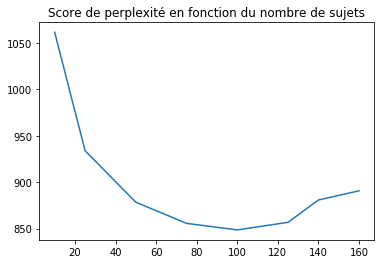

In [41]:
n_components = [10, 25, 50, 75, 100, 125, 140, 160]
scores = []
if CALC_SLOW_SECTIONS:
    for n in n_components:
        lda = sk.decomposition.LatentDirichletAllocation(n_components=n,
                                                         learning_decay=0.5,
                                                         random_state=SEED,
                                                         n_jobs=2)
        lda.fit(words_tr)
        score = lda.perplexity(words_t)
        #print(n, score)
        scores.append(score)
else:
    scores = [1062.17, 943.89, 888.53, 878.74, 884.63, 889.28, 905.38]
axes = sns.lineplot(n_components, scores);
axes.set_title("Score de perplexité en fonction du nombre de sujets");

Nous retenons 75 comme valeur optimale de `n_components`.

### Entraînement du modèle

In [67]:
lda = sk.decomposition.LatentDirichletAllocation(n_components=75,
                                                 learning_decay=0.5,
                                                 learning_method='online',
                                                 random_state=SEED,
                                                 n_jobs=1)
lda_output = lda.fit_transform(text_words)
lda

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.5,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=75, n_jobs=1,
                          perp_tol=0.1, random_state=1911,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [292]:
if EXPORT_MODELS:
    model_name = 'Classement non supervisé par LDA'
    data = (model_name, cv, lda)
    pickle.dump(data, open(MODEL2_FILE, 'wb'))

In [68]:
n_keywords = 10
words = cv.get_feature_names()
print(f"***** {n_keywords} principaux termes par sujet :")
for i, topic in enumerate(lda.components_):
    keywords = [words[i] for i in topic.argsort()[:-n_keywords-1:-1]]
    print(i, " ".join(keywords))

***** 10 principaux termes par sujet :
0 script command directory git customer environment install exit instal tool
1 location status csv check aws desktop sthree syntax region invalid
2 plot play plt audio mp reader ax show arm gui
3 button page click html show display change modal trigger inside
4 version window dependency plugin maven artifactid groupid specify machine project
5 number post account permission comment share cursor integer yes letter
6 size action cache send azure im metadata mb logic flow
7 new add create update source exist custom multiple already company
8 frame main include count std video cv cpp mat int
9 string public class return private entity object person hash equal
10 variable point apply matrix lambda normal hide compute sequence non
11 org apache core internal gradle execute security execution common configuration
12 user email password session login username auth redirect admin register
13 description enter ask basic quot standard best learn please cost


In [69]:
topic = 0
n_docs = 20
print(f"Documents avec sujet numéro {topic} :")
sorted_col = np.argsort(-lda_output[:, topic])
df.iloc[sorted_col[:n_docs].tolist()].loc[:, ['Id', 'Tags']].values.tolist()

Documents avec sujet numéro 0 :


[[57560003, {'python'}],
 [57565764, {'ubuntu'}],
 [57597704, {'shell'}],
 [57532719, {'ubuntu'}],
 [57564422, {'git', 'windows'}],
 [57588925, {'python'}],
 [57560017, {'bash', 'git', 'python'}],
 [57614140, {'git', 'gradle'}],
 [57542459, {'python'}],
 [57585547, {'android', 'node.js', 'react'}],
 [57520651, {'visual-studio'}],
 [57545995, {'macos', 'php'}],
 [57608150, {'ios', 'swift', 'xcode'}],
 [57558265, {'bash', 'python'}],
 [57518668, {'angular', 'macos'}],
 [57577424, {'bash', 'linux', 'python'}],
 [57574508, {'python'}],
 [57588344, {'.net'}],
 [57515037, {'bash'}],
 [57615575, {'bash'}]]

### Visualisation

In [45]:
def clean_tags(s):
    l = re.findall(r'\<(.*?)\>', s)
    return " ".join(l)

In [46]:
output = lda.transform(text_words) # Matrice documents-sujets
topic_names = ["S" + str(i) for i in range(lda.n_components)]
doc_names = ["D" + str(i) for i in range(len(df))]
df_topics = pd.DataFrame(np.round(output, 2), 
                         columns=topic_names, 
                         index=doc_names)
dominant_topic = np.argmax(df_topics.values, axis=1)
sorted_output = np.argsort(-output, axis=1)
df_topics['First_topic'] = sorted_output[:, 0]
df_topics['Second_topic'] = sorted_output[:, 1]
df_topics['Third_topic'] = sorted_output[:, 2]
df_topics['Tags'] = df['Tags'].values

print("Extrait de la matrice documents-sujets :")
df_topics[['First_topic', 'Second_topic', 'Third_topic', 'Tags']].head(50)

Extrait de la matrice documents-sujets :


,First_topic,Second_topic,Third_topic,Tags
D0,1,69,6,"{python, amazon}"
D1,0,41,60,{python}
D2,55,52,29,{java}
D3,41,12,57,{node.js}
D4,44,52,31,{android}
D5,29,59,45,{pandas}
D6,0,16,13,"{git, python, bash}"
D7,37,24,52,{api}
D8,73,7,68,{vue}
D9,39,45,63,"{dart, flutter}"


In [105]:
def show_topics(vectorizer, lda_model, n_words=5):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(cv, lda, n_words=15)        
df_keywords = pd.DataFrame(topic_keywords)
df_keywords.columns = [f'T{i}' for i in range(df_keywords.shape[1])]
df_keywords.index = [f'S{i}' for i in range(df_keywords.shape[0])]
print("Matrice sujets-termes")
df_keywords

Matrice sujets-termes


,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14
S0,script,command,directory,git,customer,environment,install,exit,instal,tool,editor,exe,manager,publish,cmd
S1,location,status,csv,check,aws,desktop,sthree,syntax,region,invalid,bucket,people,pull,period,writer
S2,plot,play,plt,audio,mp,reader,ax,show,arm,gui,matplotlib,mainwindow,legend,pi,light
S3,button,page,click,html,show,display,change,modal,trigger,inside,open,press,content,refresh,notification
S4,version,window,dependency,plugin,maven,artifactid,groupid,specify,machine,project,repository,plugins,due,spec,build
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S70,cluster,bite,photo,delay,pygame,definition,keyboard,popup,graphic,subscription,depth,sa,health,bill,anchor
S71,write,str,ok,split,abc,valid,large,variant,fn,construct,backup,enum,serialize,xyz,food
S72,item,td,title,tr,delete,btn,th,table,book,fa,section,row,offset,mark,author
S73,request,api,url,response,http,header,post,token,json,data,content,send,body,return,encode


### Représentation graphique des résultats

In [48]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, text_words, cv, mds='tsne')
panel

C:\Users\regclem\.conda\envs\tagging_env\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
52     -25.432968  -73.516769       1        1  6.250867
73      64.036369  -76.091515       2        1  2.779733
14       7.089995  -43.835423       3        1  2.709011
35     -53.050453  -10.377848       4        1  2.698445
48     -50.723011   57.847679       5        1  2.626870
...           ...         ...     ...      ...       ...
47     -67.877846 -207.788589      71        1  0.463699
17       0.412458   18.735754      72        1  0.429221
54     219.660934   17.724913      73        1  0.416761
27     -21.203535  233.842758      74        1  0.401532
40      64.470139 -148.188278      75        1  0.350550

[75 rows x 5 columns], topic_info=     Category          Freq       Term         Total  loglift  logprob
2958  Default  42265.000000         id  42265.000000  30.0000  30.0000
6676  Default  34043.000000      value  34043.000000  29.0000  29.0000
2233  Default  38516.000000       file  38516.000000  28.0000  28.0000
6629  Default  29867.000000       user  29867.000000  27.0000  27.0000
1447  Default  43336.000000       data  43336.000000  26.0000  26.0000
...       ...           ...        ...           ...      ...      ...
1359  Topic75    187.956289       crop    188.941437   5.6482  -4.4939
4513  Topic75    179.433992        pdb    180.419139   5.6479  -4.5403
3043  Topic75    168.124380     income    169.109528   5.6476  -4.6054
1678  Topic75    840.069253  direction   1039.567604   5.4403  -2.9966
5397  Topic75    988.725697      scale   1306.321473   5.3749  -2.8337

[3346 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0        30  0.997977          aa
1        72  0.994791         aaa
6        72  0.998528          ab
8        66  0.998823         abc
14        4  0.971071    absolute
...     ...       ...         ...
7047      3  0.264476        zero
7047     60  0.734760        zero
7054     28  0.998500        zone
7057     75  0.998770        zoom
7058     24  0.997978  zygoteinit

[4849 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[53, 74, 15, 36, 49, 17, 31, 24, 8, 4, 66, 58, 13, 60, 40, 10, 26, 50, 46, 70, 39, 1, 73, 32, 45, 67, 47, 64, 25, 34, 42, 63, 22, 33, 38, 44, 30, 12, 68, 16, 43, 20, 65, 56, 5, 75, 61, 6, 35, 23, 27, 19, 69, 9, 21, 2, 37, 71, 11, 7, 14, 59, 52, 62, 51, 72, 3, 29, 57, 54, 48, 18, 55, 28, 41])

In [49]:
# Les indices des sujets sont différents
# Par exemple le sujet no 21 de pyLDAvis est en position 28 de la matrice
df_keywords[df_keywords['T0'] == 'java']

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14
S31,java,exception,lang,util,println,method,system,invoke,main,io,throw,reflect,catch,internal,unknown


## Analyse non supervisée : LSA

In [55]:
fv = TfidfVectorizer(analyzer='word', min_df=20, max_df=0.3)
text_tfidf = fv.fit_transform(df['Text'])
print(f"Taille de la matrice Tfidf : {text_tfidf.shape}")

Taille de la matrice Tfidf : (42191, 7060)


### TruncatedSVD

In [51]:
svd_model = sk.decomposition.TruncatedSVD(n_components=75, 
                                          algorithm='randomized', 
                                          n_iter=100, 
                                          random_state=SEED)
svd_model.fit(text_tfidf)
len(svd_model.components_)

75

In [52]:
def show_topics(vectorizer, model, n_words=5):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(fv, svd_model, n_words=10)        
df_keywords = pd.DataFrame(topic_keywords)
df_keywords.columns = [f'Terme {i+1}' for i in range(df_keywords.shape[1])]
df_keywords.index = [f'Sujet {i+1}' for i in range(df_keywords.shape[0])]
df_keywords

,Terme 1,Terme 2,Terme 3,Terme 4,Terme 5,Terme 6,Terme 7,Terme 8,Terme 9,Terme 10
Sujet 1,data,file,id,value,class,user,div,function,string,return
Sujet 2,div,class,px,button,id,form,text,style,td,col
Sujet 3,column,value,table,date,row,df,data,id,array,query
Sujet 4,android,id,public,layout,java,string,app,view,int,void
Sujet 5,android,file,column,df,image,layout,row,width,date,dataframe
...,...,...,...,...,...,...,...,...,...,...
Sujet 71,map,spring,print,line,boot,post,true,false,node,field
Sujet 72,line,path,message,url,map,type,service,database,command,function
Sujet 73,state,null,sql,set,request,message,map,path,variable,li
Sujet 74,event,print,path,state,token,firebase,index,google,class,node


### Calcul direct (même résultats)

In [57]:
# Pour comparaison
U, S, Vh = np.linalg.svd(text_tfidf.toarray(), full_matrices=False)
U.shape, S.shape, Vh.shape
# M = U.S.Vh
# M matrice réelle mxn : m documents, n termes, m > n
# U, V matrices orthogonales (base orthonormée)
# S matrice diagonale des valeurs singulières
# Tailles des matrices en versions pleines : mxm mxn nxn
# Tailles des matrices en versions réduites : mxn nxn nxn

((42191, 7060), (7060,), (7060, 7060))

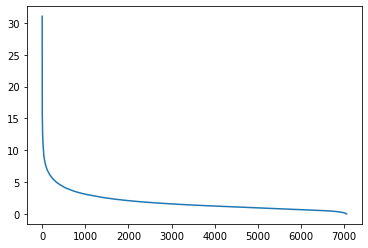

In [58]:
plt.plot(S);

In [59]:
def show_topics(vectorizer, matrix, n_words=5):
    keywords = np.array(vectorizer.get_feature_names())    
    topic_keywords = []
    for topic_weights in matrix:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs).tolist())
    return topic_keywords

show_topics(fv, Vh[:20, :])

[['dodispatch', 'socketprocessor', 'dorun', 'doinvoke', 'artifactidjunit'],
 ['file', 'android', 'java', 'app', 'python'],
 ['column', 'value', 'table', 'date', 'row'],
 ['file', 'python', 'div', 'image', 'py'],
 ['android', 'file', 'column', 'df', 'image'],
 ['string', 'public', 'class', 'int', 'array'],
 ['react', 'function', 'const', 'array', 'component'],
 ['file', 'string', 'java', 'div', 'date'],
 ['file', 'id', 'array', 'image', 'android'],
 ['date', 'android', 'form', 'input', 'format'],
 ['file', 'react', 'android', 'value', 'form'],
 ['date', 'react', 'image', 'component', 'id'],
 ['data', 'df', 'model', 'file', 'image'],
 ['public', 'cell', 'row', 'user', 'string'],
 ['self', 'table', 'td', 'var', 'function'],
 ['form', 'value', 'model', 'input', 'image'],
 ['list', 'item', 'self', 'id', 'value'],
 ['java', 'self', 'user', 'image', 'org'],
 ['value', 'self', 'div', 'id', 'string'],
 ['array', 'table', 'string', 'row', 'request']]

### Factorisation matricielle non-négative (NMF)

In [60]:
nmf = sk.decomposition.NMF(n_components=75, solver="mu")
nmf

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=75, random_state=None, shuffle=False, solver='mu', tol=0.0001,
    verbose=0)

In [61]:
W = nmf.fit_transform(text_tfidf)
H = nmf.components_
W.shape, H.shape

((42191, 75), (75, 7060))

In [62]:
# Affichage des sujets
n_words = 5
keywords = np.array(fv.get_feature_names()) 
for topic_weights in H:
    print(keywords.take((-topic_weights).argsort()[:n_words]).tolist())

['application', 'window', 'find', 'create', 'set']
['div', 'class', 'col', 'span', 'li']
['table', 'column', 'insert', 'value', 'create']
['android', 'layout', 'com', 'dp', 'parent']
['folder', 'file', 'txt', 'open', 'excel']
['public', 'class', 'void', 'new', 'private']
['file', 'upload', 'download', 'filename', 'pdf']
['self', 'def', 'init', 'class', 'print']
['df', 'column', 'dataframe', 'panda', 'pd']
['date', 'format', 'day', 'month', 'mm']
['image', 'img', 'png', 'jpg', 'upload']
['component', 'prop', 'react', 'render', 'const']
['data', 'frame', 'response', 'request', 'console']
['array', 'arr', 'np', 'value', 'numpy']
['user', 'role', 'auth', 'login', 'profile']
['value', 'form', 'field', 'type', 'submit']
['url', 'http', 'request', 'com', 'header']
['java', 'org', 'apache', 'jar', 'springframework']
['list', 'append', 'add', 'sort', 'name']
['id', 'null', 'join', 'type', 'group']
['import', 'module', 'export', 'print', 'py']
['page', 'html', 'link', 'load', 'click']
['model', 

## Comparaison des résultats
Pour l'instant LDA vs labels originaux seulement.

### Score de correspondance

In [197]:
all_tags = list(functools.reduce(set.union, df['Tags']))
" ".join(map(transform_label_name, all_tags[:20]))

'powershell unit-testing dotnet google-app web arrays apache django csv ajax pdf intellij logging visual-studio sorting dart csharp string jquery python'

In [204]:
replace_list = [('vt100', 'vthundred'),
                ('c#', 'csharp'),
                ('c', 'clanguage'),
                ('c++11', 'cppeleven'),
                ('c++', 'cpp'),
                ('g++', 'gpp'),
                ('s3', 'sthree'),
                ('x64', 'xsixtyfour'),
                ('i386', 'ithreeeightsix'),
                ('r', 'rsoftware'),
                ('.net', 'dotnet'),
                ('google-chrome', 'chrome'),
                ('node.js', 'node'),
                ('ionic-framework', 'ionic')]
            
def transform_label_name(l):
    for w1, w2 in replace_list: # À améliorer
        if l == w1:
            l = w2
    return l

In [234]:
dominant_topics = np.argmax(lda_output, axis=1)
keywords = np.array(cv.get_feature_names())
n = len(keywords)
scores = []
not_found = set()
scores_by_tag = dict()

for row in range(lda_output.shape[0]): # Pour chaque document
    first_topic = dominant_topics[row] # Sujet dominant
    topic_keywords = keywords.take((lda.components_[first_topic]).argsort())
    locs = []
    # Itération sur les labels et sous-labels du document (séparés par '-')
    doc_tags = df['Tags'].iloc[row]
    for t in '-'.join(doc_tags).split('-'):
        loc = np.where(topic_keywords == transform_label_name(t))
        if len(loc[0]) > 0: # Label trouvé   
            loc = loc[0][0] # Extrait la position
            locs.append(loc)
            if t in scores_by_tag:
                scores_by_tag[t].append(loc / (n-1))
            else:
                scores_by_tag[t] = [loc / (n-1)]
        else: # Label introuvable
            locs.append(0)
            not_found.add(t)
    scores.append(sum(locs)/len(locs))
    
print(f"Note maximale (nombre de mots par sujet) : {n-1}")
avg = sum(scores) / len(scores) 
print(f"Note moyenne : {avg:.0f}")
print(f"Note moyenne normalisée : {avg / (n-1):.2f}")
print(f"{len(not_found)} labels introuvables :")
print(" ".join(not_found))

Note maximale (nombre de mots par sujet) : 7059
Note moyenne : 3788
Note moyenne normalisée : 0.54
26 labels introuvables :
sheets scraping for forms arrays rails windows jestjs loops if logging sorting maps on ecma pandas learning ionic4 vb.net ggplot2 tsql asp.net css keras ios testing


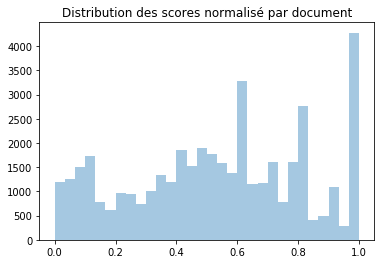

In [263]:
axes= sns.distplot(scores / max(scores), kde=False, bins=30);
axes.set_title("Distribution des scores normalisé par document");

In [246]:
def list_avg(l):
    return sum(l) / len(l)

score_by_tag = { t:list_avg(scores_by_tag[t]) for t in scores_by_tag }

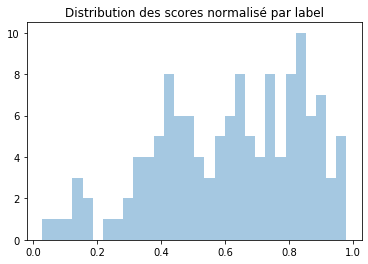

In [262]:
axes= sns.distplot(list(score_by_tag.values()), kde=False, bins=30);
axes.set_title("Distribution des scores normalisé par label");

In [251]:
for item in sorted(score_by_tag.items(), key=operator.itemgetter(1)):
    print(f"{item[0]} ({item[1]:.2f})", end=' ')

postgresql (0.03) powershell (0.08) qt (0.10) php (0.13) rest (0.14) regex (0.15) machine (0.17) mongo (0.18) python (0.23) unit (0.28) node.js (0.30) linux (0.31) woocommerce (0.31) mysql (0.32) macos (0.33) pyspark (0.33) wordpress (0.35) xamarin (0.36) loop (0.37) multithreading (0.37) xcode (0.38) vue (0.38) unity (0.38) visual (0.41) numpy (0.41) typescript (0.41) web (0.42) shiny (0.42) object (0.43) scikit (0.43) ruby (0.43) pdf (0.43) scala (0.44) performance (0.44) server (0.45) list (0.45) react (0.46) tkinter (0.46) symfony (0.47) opencv (0.47) xml (0.47) studio (0.47) rust (0.48) sqlite (0.50) npm (0.50) oracle (0.51) matplotlib (0.52) string (0.53) vba (0.53) nginx (0.54) maven (0.55) r (0.55) ssl (0.57) svg (0.57) cloud (0.59) c++ (0.59) wpf (0.59) spring (0.60) ubuntu (0.60) shell (0.61) c# (0.61) chrome (0.62) webpack (0.62) apache (0.64) csv (0.64) deep (0.64) app (0.65) class (0.65) ansible (0.66) dictionary (0.66) angular (0.66) algorithm (0.67) amazon (0.67) android

### Comparaison par fréquence

In [278]:
def get_topic_keywords(topic_index, n_keywords=5):
    topic = lda.components_[topic_index]
    keywords = [words[i] for i in (-topic).argsort()[:n_keywords]]
    return " ".join(keywords)

df_topics = pd.Series(dominant_topics).value_counts().reset_index()
df_topics.columns = ['Sujet', 'Nombre']
df_topics['Termes'] = df_topics['Sujet'].apply(get_topic_keywords)
df_topics.iloc[:10]

,Sujet,Nombre,Termes
0,52,5989,one find make change follow
1,73,2001,request api url response http
2,59,1477,table query select null sql
3,45,1392,column row df data rsoftware
4,35,1388,px width style height content
5,48,1240,new void public int override
6,57,1195,file image path filename folder
7,16,1162,self python py line import
8,30,1156,build project package config lib
9,14,1150,data object true false end


In [283]:
def add_sets_as_lists(s1, s2):
    return list(s1) + list(s2)
all_tags = functools.reduce(add_sets_as_lists, df['Tags'])
collections.Counter(all_tags).most_common(10)

[('java', 8156),
 ('python', 6977),
 ('c#', 2569),
 ('android', 2500),
 ('react', 2165),
 ('php', 2065),
 ('html', 2056),
 ('angular', 1534),
 ('r', 1376),
 ('css', 1340)]

## Analyse par plongement lexical [pas une priorité]

In [ ]:
model = spacy.load("en_core_web_md")

In [ ]:
def vector_norm(v):
    return math.sqrt(np.dot(v, v))

def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / vector_norm(v1) / vector_norm(v2)

def similarity(t1, t2):
    return round(cosine_similarity(t1.vector, t2.vector), 3)

In [ ]:
tokens = model("boy son girl daughter")
  
for token in tokens:     
    print(token.text, token.has_vector, token.vector_norm) 

In [ ]:
t1, t2, t3, t4 = (tokens[i] for i in range(len(tokens)))
print("Similarité entre t1 et t2 :", tokens[0].similarity(tokens[1]))
v12 = t2.vector - t1.vector
v34 = t4.vector - t3.vector
print("Similarité entre t2-t1 et t4-t3 :", cosine_similarity(v12, v34))
v12 = t2.vector + t1.vector
v34 = t4.vector + t3.vector
print("Similarité entre t1+t2 et t3+t4 :", cosine_similarity(v12, v34))

In [ ]:
def sort_by_similarity(base_vector):
    words = model.vocab
    distances = [(cosine_similarity(base_vector, w.vector), w) for w in words]
    return sorted(distances, key=lambda t: t[0], reverse=True)

In [ ]:
v = t1.vector - t2.vector + t4.vector # boy - son + daughter
words = list({w for w in model.vocab if w.has_vector and w.orth_.islower()})
print(f"Nombre de mots : {len(words)}")
words.sort(key=lambda w: cosine_similarity(w.vector, v)) 
words.reverse()
print("Mot le plus semblable :", words[0].orth_)

On a donc : boy - son = girl - daughter

In [ ]:
v = -t1.vector + t2.vector + t3.vector # -boy + son + girl
words = list({w for w in model.vocab if w.has_vector and w.orth_.islower()})
print(f"Nombre de mots : {len(words)}")
words.sort(key=lambda w: cosine_similarity(w.vector, v)) 
words.reverse()
print("Mot le plus semblable :", words[0].orth_)
print("2e mot le plus semblable :", words[1].orth_)

In [ ]:
tokens = model("boy brother girl sister")
  
for token in tokens:     
    print(token.text, token.has_vector, token.vector_norm) 
t1, t2, t3, t4 = (tokens[i] for i in range(len(tokens)))

In [ ]:
v = t3.vector - (t1.vector + t2.vector) # girl - (boy - brother)
v = t1.vector - t2.vector + t4.vector # boy - brother + sister
words = list({w for w in model.vocab if w.has_vector and w.orth_.islower()})
print(f"Nombre de mots : {len(words)}")
words.sort(key=lambda w: cosine_similarity(w.vector, v)) 
words.reverse()
print("Mot le plus semblable :", words[0].orth_)
#print("2e mot le plus semblable :", words[1].orth_)